# Kontrolloierte Inference mit LoRA, ControlNet und Stable Diffusion XL

## Prüfen ob das Notebook mit GPU-Beschleunigung läuft

In den Einstellungen von Google Colab sollte die T4 GPU-Beschleunigung ausgewählt sein. Ob dies der Fall ist lässt sich mit diesem einfachen Befehl prüfen. Im Erfolgsfall wird die Zeile GPU 0: Tesla T4 (UUID: XXXXX) augegeben, wobei XXXdurch eine eindeutige ID ersetzt wird.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-89d12d5e-801b-c975-0131-644d1fe329ee)


## Die nötigen Bibliotheken installieren

In [2]:
!pip install -q accelerate controlnet_aux transformers safetensors opencv-python diffusers

## Inferenz mit SDXL 1.0 und LoRA + ControlNet

In [3]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL, UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [4]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

In [30]:
!wget "https://images.unsplash.com/photo-1546492086-57c4c2223463?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1974&q=80" -O barbar-pose5.jpg


['--2023-09-10 06:41:10--  https://images.unsplash.com/photo-1546492086-57c4c2223463?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1974&q=80',
 'Resolving images.unsplash.com (images.unsplash.com)... 151.101.78.208, 2a04:4e42:12::720',
 'Connecting to images.unsplash.com (images.unsplash.com)|151.101.78.208|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 691650 (675K) [image/jpeg]',
 'Saving to: ‘barbar-pose5.jpg’',
 '',
 '',
 'barbar-pose5.jpg      0%[                    ]       0  --.-KB/s               ',
 'barbar-pose5.jpg    100%[===================>] 675.44K  --.-KB/s    in 0.05s   ',
 '',
 '2023-09-10 06:41:10 (12.8 MB/s) - ‘barbar-pose5.jpg’ saved [691650/691650]',
 '']

In [31]:
image = load_image("./barbar-pose5.jpg")

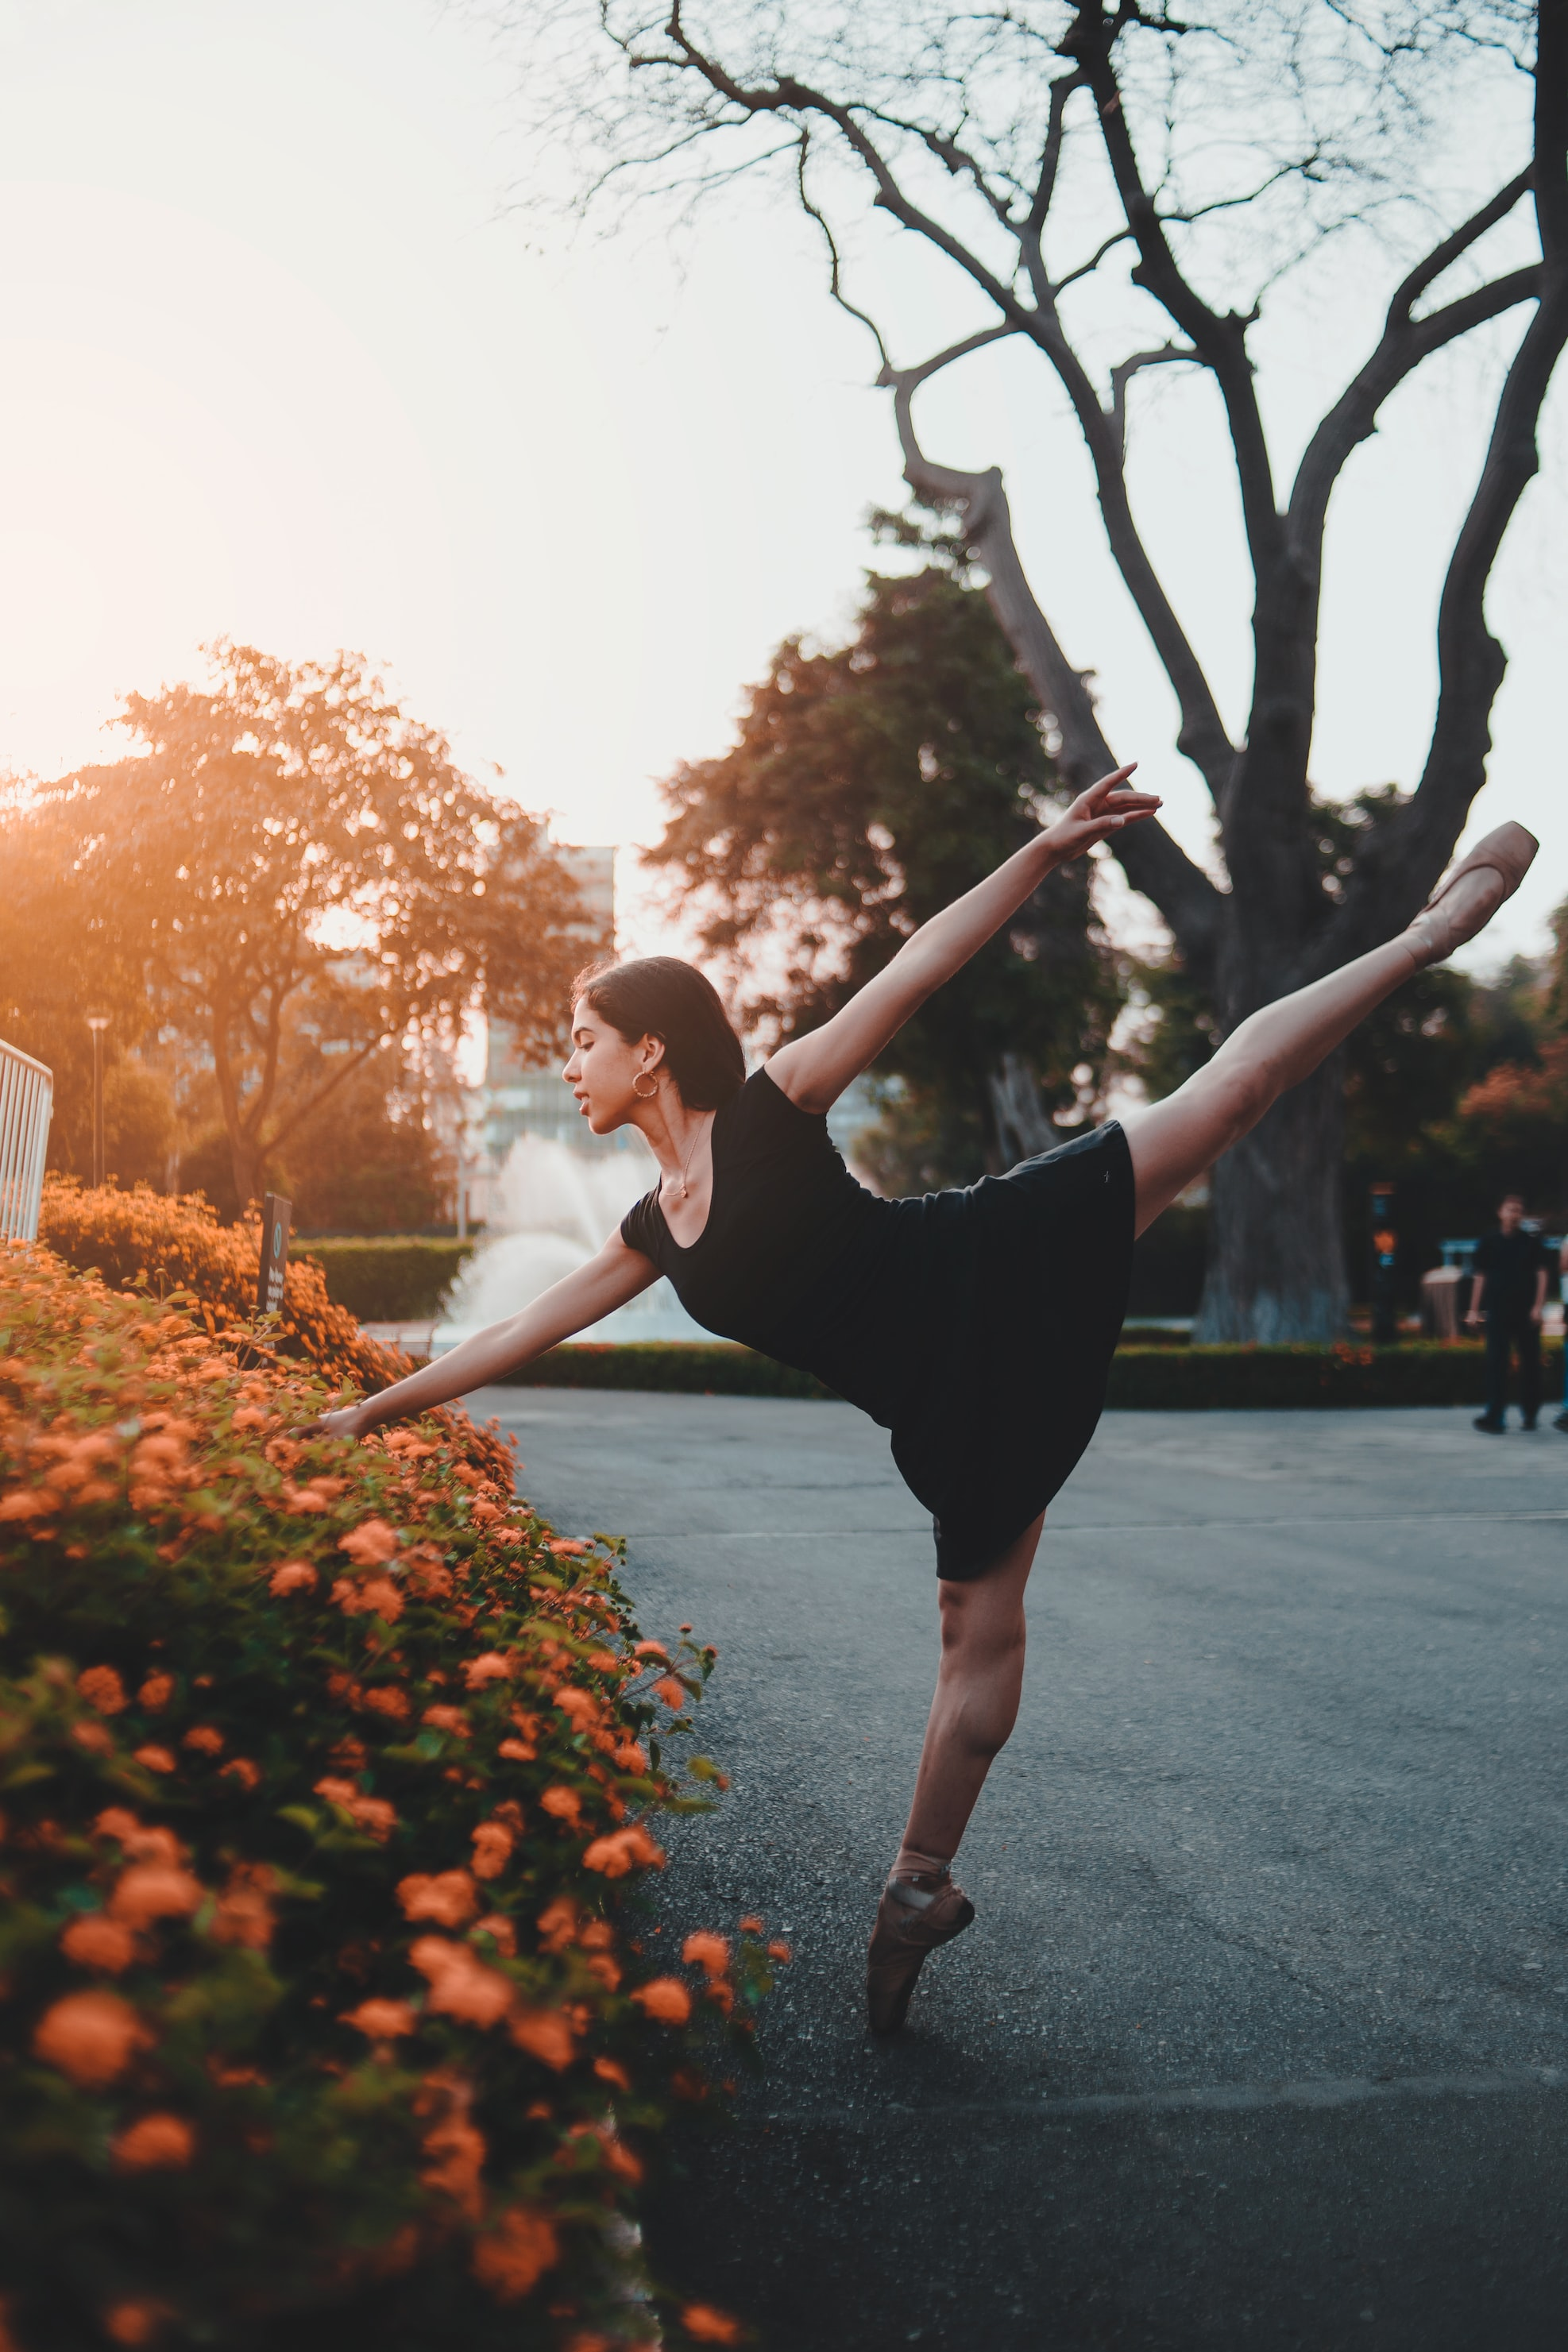

In [32]:
image

In [33]:
openpose_image = openpose(image)

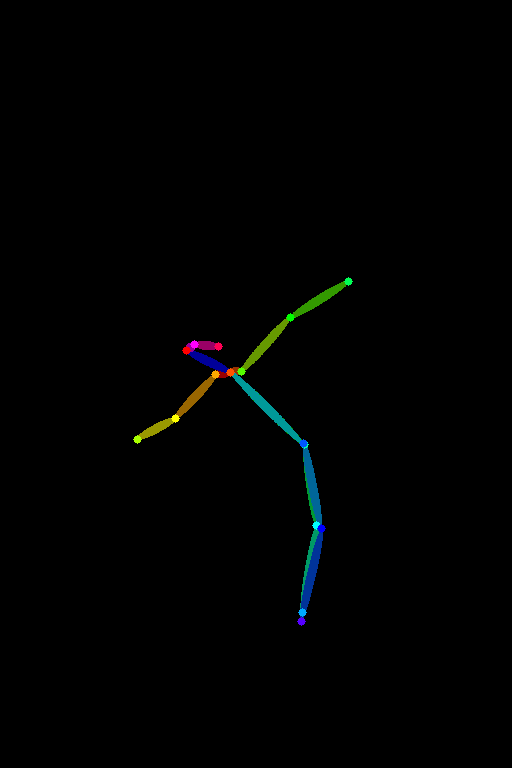

In [34]:
openpose_image

In [57]:
openpose_image.save("pose2.png")

In [10]:
controlnet = ControlNetModel.from_pretrained(
    "thibaud/controlnet-openpose-sdxl-1.0",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
)
pipe.load_lora_weights("Rawar/heman-toy-lora-trained-sdxl")
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
prompt = "photo of he-man toy in a dark foggy forest, hard lighting, high quality, 4k"
negative_prompt = "low quality, bad quality, sketches"

In [36]:
controlnet_conditioning_scale = 0.4
n_steps = 50
seed = 3
cross_attention_scale = 0.8

In [54]:
images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    num_images_per_prompt=1,
    image=openpose_image.resize((1024, 1024)),
    generator=torch.manual_seed(8),
).images

  0%|          | 0/30 [00:00<?, ?it/s]

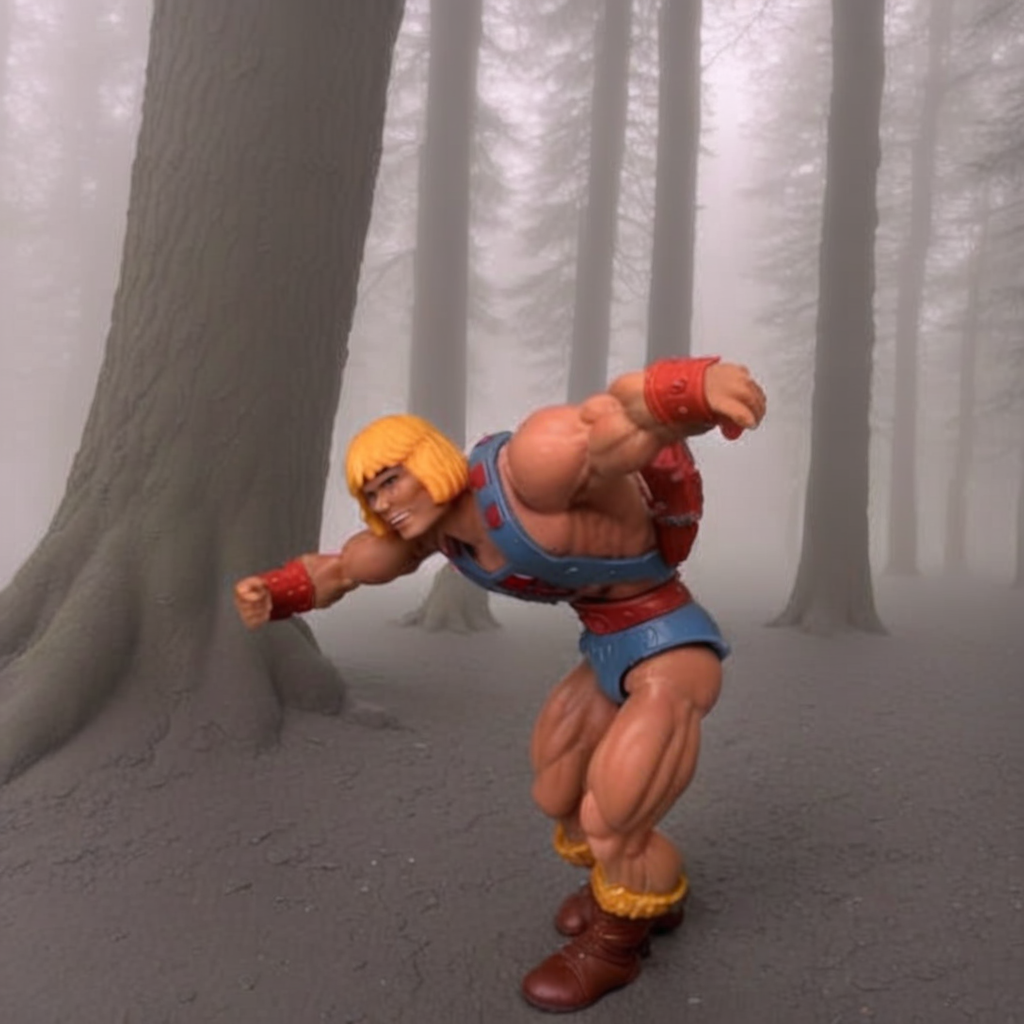

In [55]:
images[0]

In [58]:
images[0].save(f"controlnet05.png")

## Prompt sund Parameter

In [ ]:
#prompt = "from the muscal of photo of he-man, in a dark foggy forest, hard lighting"
prompt = "photo of he-man, in a dark foggy forest, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

In [ ]:
controlnet_conditioning_scale = 0.4
n_steps = 50
seed = 3
cross_attention_scale = 0.8

In [ ]:
images = pipe(
  prompt,
  negative_prompt=negative_prompt,
  image=image,
  controlnet_conditioning_scale=controlnet_conditioning_scale,
  num_inference_steps=n_steps,
  generator=torch.Generator(device='cuda').manual_seed(seed),
  cross_attention_kwargs={"scale": cross_attention_scale},
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
images[0]

In [ ]:
images[0].save(f"ix_logo6.png")